# Pittsburgh Neighborhood Safety
> By Jared Peters
---
## Datasets
- [Police Incident Blotter (30 Day)](https://data.wprdc.org/dataset/police-incident-blotter)
- [Pittsburgh American Community Survey 2015 - Total Population](https://data.wprdc.org/dataset/pittsburgh-american-community-survey-2015-miscellaneous-data/resource/82f29015-6905-4b1c-8300-afe9bb2231b3)

## Step 1: Setup
- Import pandas and matplotlib
- Import blotter dataframe
- Refine dataset columns

In [23]:
import pandas as pd
# % matplotlib inline

In [24]:
# Import online Blotter data
blotter_data = pd.read_csv("https://data.wprdc.org/datastore/dump/1797ead8-8262-41cc-9099-cbc8a161924b")
blotter_data.columns

Index(['PK', 'CCR', 'HIERARCHY', 'INCIDENTTIME', 'INCIDENTLOCATION',
       'CLEAREDFLAG', 'INCIDENTNEIGHBORHOOD', 'INCIDENTZONE',
       'INCIDENTHIERARCHYDESC', 'OFFENSES', 'INCIDENTTRACT',
       'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION', 'X', 'Y'],
      dtype='object')

There are many columns, but we only need a few.

In [25]:
# Filter out unnecessary columns
blotter_data = blotter_data[['INCIDENTNEIGHBORHOOD', 'INCIDENTHIERARCHYDESC', 'HIERARCHY']]
blotter_data.head(10)

,INCIDENTNEIGHBORHOOD,INCIDENTHIERARCHYDESC,HIERARCHY
0,Strip District,HIT AND RUN,27
1,Carrick,CRIM MISCHIEF,14
2,Lincoln-Lemington-Belmar,HARRASSMENT,10
3,Central Business District,HIT AND RUN,27
4,East Liberty,99,0
5,South Side Slopes,CRIM MISCHIEF,14
6,Central Business District,THEFT,6
7,Homewood South,CRIM MISCHIEF,14
8,Brighton Heights,HIT AND RUN,27
9,Middle Hill,99,0


## Step 2: Determine Danger Level
- Create a function to weight incidents based on their

There are too many incident types to weight each one

In [26]:
blotter_data['INCIDENTHIERARCHYDESC'].nunique()

97

We can look at the most common and group them by severity

In [27]:
# Let's take the top 15 and group them into categories for their severity
blotter_data['INCIDENTHIERARCHYDESC'].value_counts().head(20)

99                                551
HIT AND RUN                       281
THEFT                             273
SIMPLE ASSAULT                    161
THEFT FROM AUTO                   133
HARRASSMENT                       130
CRIM MISCHIEF                     117
STOLEN PROPERTY - OTHER            72
AIDED CASE                         71
BURGLARY                           66
FOUND PROPERTY                     65
HARRASSMENT/THREAT/ATTEMPT/PHY     62
AGG-ASSAULT                        55
TERRORISTIC THREATS                48
DEAD ON ARRIVAL (DOA)              47
STOLEN PROPERTY                    45
THEFT BY DECEPTION                 44
MISCELLANEOUS INVESTIGATION        44
MENTAL 201/302                     43
RETAIL THEFT (SHOPLIFTING)         42
Name: INCIDENTHIERARCHYDESC, dtype: int64

Most of them can be seen as moderate, but some are more minor or severe

In [28]:
severe_incidents = ["BURGLARY", "DEAD ON ARRIVAL (DOA)"]
minor_incidents = ["99", "CRIM MISCHIEF", "RETAIL THEFT (SHOPLIFTING)"]
# Any other incidents will be considered moderate

We'll now make a 'DANGER_LEVEL' column to describe the weighted rating of the offense

In [29]:
def get_incident_weight(incident: str):
    if incident in severe_incidents:
        return 150
    if incident in minor_incidents:
        return 75
    return 100

blotter_data['DANGER_LEVEL'] = blotter_data['INCIDENTHIERARCHYDESC'].map(get_incident_weight)
blotter_data.head()

,INCIDENTNEIGHBORHOOD,INCIDENTHIERARCHYDESC,HIERARCHY,DANGER_LEVEL
0,Strip District,HIT AND RUN,27,100
1,Carrick,CRIM MISCHIEF,14,75
2,Lincoln-Lemington-Belmar,HARRASSMENT,10,100
3,Central Business District,HIT AND RUN,27,100
4,East Liberty,99,0,75


Once we have these danger levels, we can group the data by Neighborhood and aggregate by their total danger level.

In [30]:
nb_groups = blotter_data.groupby('INCIDENTNEIGHBORHOOD')
neighborhood_data = nb_groups.agg({'DANGER_LEVEL':'sum'})
neighborhood_data.head()

,DANGER_LEVEL
INCIDENTNEIGHBORHOOD,
Allegheny Center,2275
Allegheny West,800
Allentown,3675
Arlington,2300
Arlington Heights,425


Here are the top 10 safest and most dangerous neighborhoods, based purely on DANGER_LEVEL

<AxesSubplot:xlabel='Safest Neighborhoods', ylabel='Danger per Capita'>

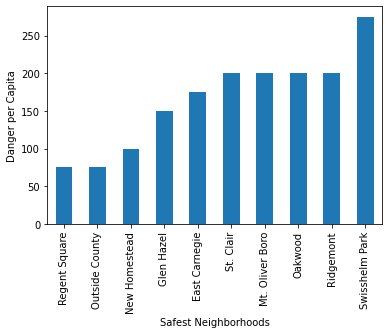

In [31]:
neighborhood_data = neighborhood_data.sort_values(by="DANGER_LEVEL")
neighborhood_data['DANGER_LEVEL'].head(10).plot.bar(xlabel='Safest Neighborhoods', ylabel='Danger per Capita')

<AxesSubplot:xlabel='Most Dangerous Neighborhoods', ylabel='Danger per Capita'>

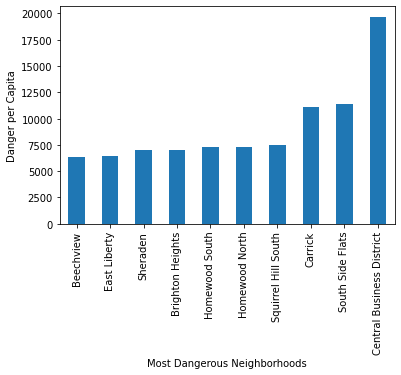

In [32]:
neighborhood_data['DANGER_LEVEL'].tail(10).plot.bar(xlabel="Most Dangerous Neighborhoods", ylabel='Danger per Capita')

# Step 3: Account for Population
This data still may not be a fair indicator, as higher populations will tend to have more crime due to having more people.

We can account for this by importing estimated population data.

In [37]:
population_data = pd.read_csv('https://data.wprdc.org/dataset/5b18c198-474c-4723-b735-cc5220ad43cc/resource/82f29015-6905-4b1c-8300-afe9bb2231b3/download/total-population.csv', index_col='Neighborhood')
population_data.head()

,Id,Estimate; Total,Margin of Error; Total
Neighborhood,,,
Allegheny Center,1,1411.0,196.000000
Allegheny West,2,343.0,96.000000
Allentown,3,2558.0,449.773276
Arlington,4,1852.0,348.188168
Arlington Heights,5,272.0,126.000000


We can add the 'Estimate; Total' data to our current neighborhood data by creating a new column.

In [38]:
neighborhood_data['POPULATION'] = population_data['Estimate; Total']
neighborhood_data.head()

,DANGER_LEVEL,POPULATION
INCIDENTNEIGHBORHOOD,,
Regent Square,75,1033.0
Outside County,75,NaN
New Homestead,100,973.0
Glen Hazel,150,716.0
East Carnegie,175,610.0


Now, we can join our dataframes and create a new column for danger level per capita

In [39]:
neighborhood_data['DANGER_PER_CAPITA'] = neighborhood_data['DANGER_LEVEL'] / neighborhood_data['POPULATION']
neighborhood_data.head()

,DANGER_LEVEL,POPULATION,DANGER_PER_CAPITA
INCIDENTNEIGHBORHOOD,,,
Regent Square,75,1033.0,0.072604
Outside County,75,NaN,NaN
New Homestead,100,973.0,0.102775
Glen Hazel,150,716.0,0.209497
East Carnegie,175,610.0,0.286885


# Conclusion

This 'DANGER_PER_CAPITA' can be used as our indicator for safety, so let's look at the most and least safe neighborhoods

<AxesSubplot:xlabel='Safest Neighborhoods', ylabel='Danger per Capita'>

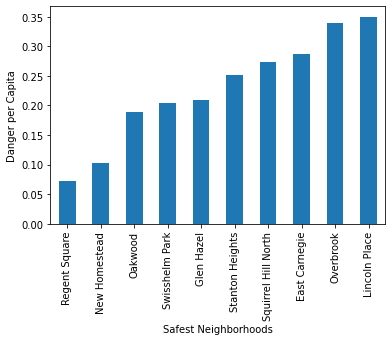

In [40]:
neighborhood_data = neighborhood_data.sort_values(by="DANGER_PER_CAPITA").dropna()
neighborhood_data['DANGER_PER_CAPITA'].head(10).plot.bar(xlabel='Safest Neighborhoods', ylabel='Danger per Capita')

<AxesSubplot:xlabel='Most Dangerous Neighborhoods', ylabel='Danger per Capita'>

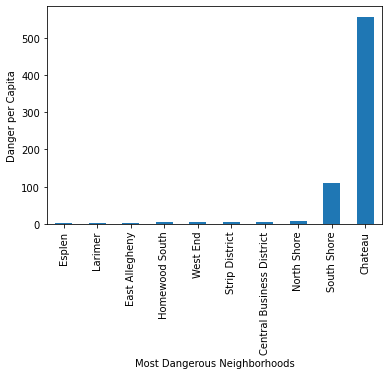

In [41]:
neighborhood_data['DANGER_PER_CAPITA'].tail(10).plot.bar(xlabel="Most Dangerous Neighborhoods", ylabel='Danger per Capita')

Woah! Why is Chateau's danger rating so high?

Chateau has a very small is population, and mainly consists of [warehouses](https://en.wikipedia.org/wiki/Chateau_(Pittsburgh)), so it could be possible that people go to this unpopulated neighborhood to stay under the radar and commit crime

Based on calculations including the amount of police incidents reported, the type of incidents, and the neighborhood populations, the final rankings from safest to most dangerous are as follows:

In [42]:
# Print each of the neighborhoods (the index of the df) on separate lines in order
for rank, nb in enumerate(neighborhood_data.index, 1):
    print(f"{rank}. {nb}")

1. Regent Square
2. New Homestead
3. Oakwood
4. Swisshelm Park
5. Glen Hazel
6. Stanton Heights
7. Squirrel Hill North
8. East Carnegie
9. Overbrook
10. Lincoln Place
11. Shadyside
12. Banksville
13. Morningside
14. Brookline
15. Bloomfield
16. North Oakland
17. Squirrel Hill South
18. Greenfield
19. Polish Hill
20. Point Breeze
21. Garfield
22. Windgap
23. Mount Washington
24. Westwood
25. Upper Lawrenceville
26. Highland Park
27. Central Oakland
28. Beltzhoover
29. Ridgemont
30. Lower Lawrenceville
31. Upper Hill
32. South Oakland
33. Central Lawrenceville
34. Terrace Village
35. Marshall-Shadeland
36. St. Clair
37. Fairywood
38. Duquesne Heights
39. Spring Garden
40. Beechview
41. Friendship
42. Chartiers City
43. Troy Hill
44. Summer Hill
45. Perry North
46. Brighton Heights
47. Lincoln-Lemington-Belmar
48. Spring Hill-City View
49. Bluff
50. Crafton Heights
51. Carrick
52. West Oakland
53. Knoxville
54. Hazelwood
55. East Liberty
56. Hays
57. Sheraden
58. South Side Slopes
59. Arl